# Graph visualization

This notebook demonstrates the use of the TrustGraph triple store API to fetch information from the knowledge graph. This information is then visualized using the networkX graph visualisation library.  This notebook was executed against a running TrustGraph loaded with the space shuttle challenger report from NASA located here:

https://ntrs.nasa.gov/citations/19860015255

In [1]:
!pip install networkx
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt
import textwrap

In [3]:
# ID of flow
flow = "default"
base_url = "http://localhost:8088"

In [4]:
# URL of the TrustGraph triples-query API
url = f"{base_url}/api/v1/flow/{flow}/service/triples"

In [5]:
# Utility function, given a label works backward to find the URI of the graph node associated with that label
def get_entity(label):
    
    input = {
        "p": {
            "v": "http://www.w3.org/2000/01/rdf-schema#label",
            "e": True,
        },
        "o": {
            "v": label,
            "e": False,
        },
        "limit": 1,
    }

    # Invoke the API, input is passed as JSON
    resp = requests.post(url, json=input)
    if resp.status_code != 200:
        raise RuntimeError(f"Got status code {resp.status_code}")
    try:
        resp = resp.json()
    except:
        raise RuntimeError("JSON decode failed")

    #print(resp)
    for row in resp["response"]:
        return row["s"]["v"]

    raise RuntimeError("Couldn't resolve entity")

In [6]:
# Given an entity URI, find the label
def get_label(ent):

    if ent == "http://www.w3.org/2000/01/rdf-schema#label": return "label"
    if ent == "https://schema.org/subjectOf": return "subject of"
    if ent.startswith("https://trustgraph.ai/doc/"): return "source document"
    if ent == "http://www.w3.org/2004/02/skos/core#definition": return "definition"
    if ent == "https://schema.org/keywords": return "keyword"
    if ent == "https://schema.org/description": return "keyword"
    if ent == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type": return "type"
    if ent == "https://schema.org/copyrightNotice": return "(c) notice"
    if ent == "https://schema.org/copyrightHolder": return "(c) held"
    if ent == "https://schema.org/copyrightYear": return "(c) year"

    if not ent.startswith("http"): return ent
        
    input = {
        "s": {
            "v": ent,
            "e": True,
        },
        "p": {
            "v": "http://www.w3.org/2000/01/rdf-schema#label",
            "e": True,
        },
        "limit": 1,
    }

    # Invoke the API, input is passed as JSON
    resp = requests.post(url, json=input)
    if resp.status_code != 200:
        raise RuntimeError(f"Got status code {resp.status_code}")
    try:
        resp = resp.json()
    except:
        raise RuntimeError("JSON decode failed")

    for row in resp["response"]:
        label = row["o"]["v"]
        return label
        
    # If no label, just dump the entity
    return ent

In [7]:
# Given a graph node specified by URI, find related edges which start at that node
def get_related_edges(s, limit=20, follows=1):
    
    input = {
        "s": {
            "v": s,
            "e": True,
        },
        "limit": limit, # Limit in number of edges to return
    }

    # Invoke the API, input is passed as JSON
    resp = requests.post(url, json=input)
    if resp.status_code != 200:
        raise RuntimeError(f"Got status code {resp.status_code}")
    try:
        resp = resp.json()
    except:
        raise RuntimeError("JSON decode failed")

    #print(resp)
    res = [
        [s, row["p"]["v"], row["o"]["v"]]
        for row in resp["response"]
    ]

    if follows > 1:
        seeds = [ r[2] for r in res ]
        for se in seeds:
            if se.startswith("http"):
                res.extend(get_related_edges(se, limit, follows - 1))

    return res

In [8]:
# Get some useful starting seeds
shuttle = get_entity("Space Shuttle")
tank = get_entity("fuel tank")
oring = get_entity("O-ring")

In [9]:
# Follow edges start at the seeds above to build a collection of statements
edges = []
edges.extend(get_related_edges(shuttle))
edges.extend(get_related_edges(tank))
edges.extend(get_related_edges(oring))

In [10]:
edges

[['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/became',
  'focus of NASAs near-term future'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/can-perform',
  'perform'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/completed',
  'four test flights'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/composed-of',
  'http://trustgraph.ai/e/expendable-external-fuel-tank'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/composed-of',
  'http://trustgraph.ai/e/orbiter'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/composed-of',
  'http://trustgraph.ai/e/solid-rocket-boosters'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/designed-to-deliver',
  '32,000 pounds'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/designed-to-deliver',
  '65,000 pounds of payload'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgrap

# Visualization

To make networkX happy this information needs to be modeled in a different way.  This information gets converted into various forms which use numeric IDs instead of strings.

In [11]:
# Produces a list of entities which are sources and objects.  This list does not contain predicates
ents = list(set([e[0] for e in edges] + [e[2] for e in edges]))

# URI to ID mapping in both directions
id2label = { ix: ent for ix, ent in enumerate(ents) }
label2id = { ent: ix for ix, ent in enumerate(ents) }

# ID to human-readable label for nodes
id2name = { ix: get_label(ent) for ix, ent in enumerate(ents) }

In [12]:
# Edge list, list of (subject, object) pairs
network_e = [(label2id[e[0]], label2id[e[2]]) for e in edges]

In [13]:
# Mapping from edge to edge label
edge_labels = {
    (label2id[e[0]], label2id[e[2]]): get_label(e[1])
    for e in edges
}

In [14]:
# Create a directed graph using NetworkX
network = nx.DiGraph()

# Add edges
network.add_edges_from(network_e)

# Visualize the directed graph using a spring layout - this computes positions for all nodes
pos = nx.spring_layout(network)

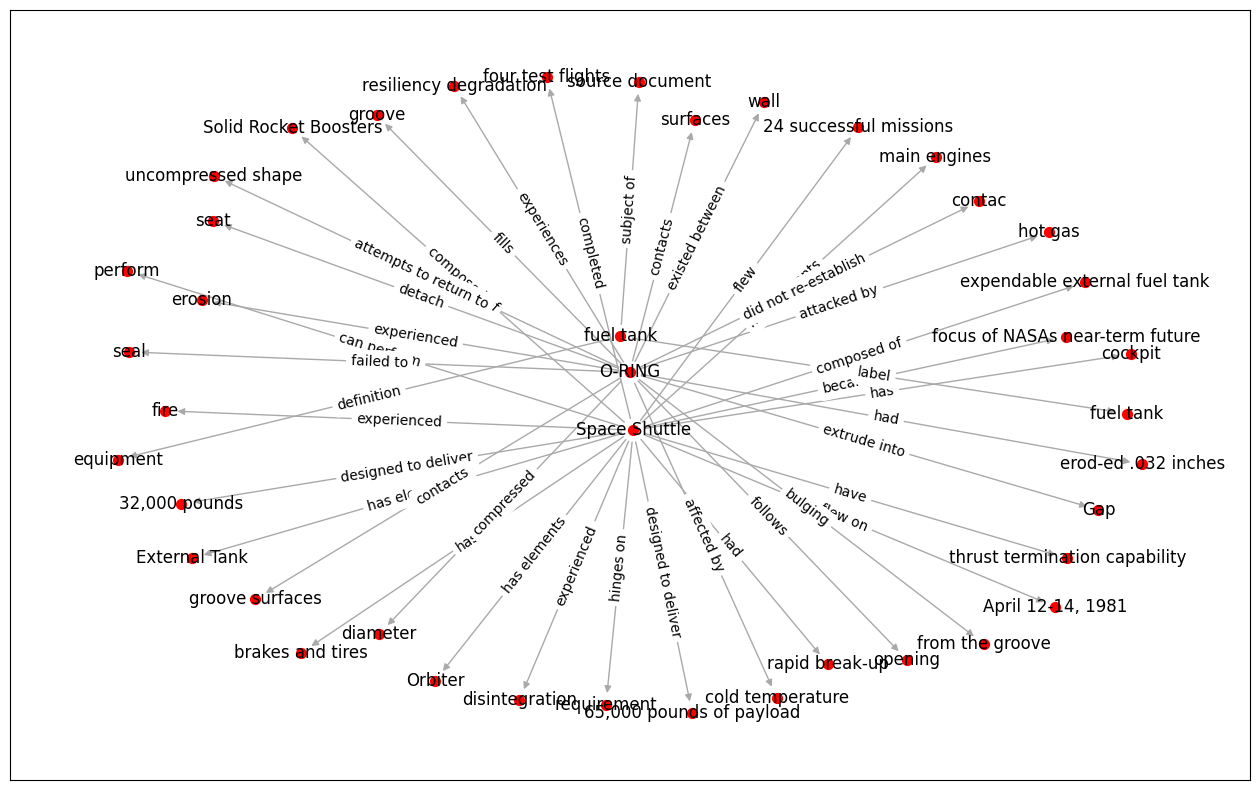

In [15]:
# Get drawing.  Nice big image frame
plt.figure(figsize=(16,10))

# Draw nodes, edges, labels on nodes and labels on edges
nx.draw_networkx_nodes(network, pos, node_shape='o', node_color='red', node_size=50)
nx.draw_networkx_edges(network, pos, edge_color='darkgray')
nx.draw_networkx_labels(network, pos, labels=id2name)
nx.draw_networkx_edge_labels(network, pos, edge_labels=edge_labels)

# Show the pic
plt.show()